In [1]:
import sys, os


# specify GMTSAR installation path
PATH = os.environ['PATH']
if PATH.find('GMTSAR') == -1:
    PATH = os.environ['PATH'] + ':/usr/local/GMTSAR/bin/'
    %env PATH {PATH}

In [2]:
import xarray as xr
import numpy as np

import shutil
import pandas as pd
import geopandas as gpd
import json

from dask.distributed import Client
import dask


# plotting modules
import pyvista as pv
# magic trick for white background
pv.set_plot_theme("document")
import panel
panel.extension(comms='ipywidgets')
panel.extension('vtk')
from contextlib import contextmanager
import matplotlib.pyplot as plt


@contextmanager
def mpl_settings(settings):
    original_settings = {k: plt.rcParams[k] for k in settings}
    plt.rcParams.update(settings)
    yield
    plt.rcParams.update(original_settings)


plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


# define Pandas display settings
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

from pygmtsar import S1, Stack, tqdm_dask, ASF, Tiles, XYZTiles

In [3]:
# simple Dask initialization
if 'client' in globals():
    client.close()

client = Client()

/opt/conda/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33261 instead
  warnings.warn(
2024-11-11 13:03:43,624 - distributed.scheduler - WARNING - Detected different `run_spec` for key ('broadcast_to-concatenate-getitem-mean_chunk-reshape-trim-mean_agg-aggregate-e69741e77b88b83543d2d1d9578aa6b7', 2, 0, 0) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x7f594017a0c0>, ((functools.partial(<function mean_agg at 0x7f590b570c20>, dtype=dtype('float32'), axis=(2, 4), keepdims=

In [4]:
def clear_directory(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # Remove file
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # Remove directory
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')

In [5]:
SUBSWATH = 2
FILENAMES = [
    '2018'
]
FILENAME = FILENAMES[0]

def get_sar_1_collections_from(file_path):
    with open (file_path, 'r') as f:
        scenes = f.readlines()
    return [f.strip() for f in scenes]

SAR_1_COLLECTIONS_FILE = f'data/bursts/manila/{FILENAME}.txt'
scenes = get_sar_1_collections_from(SAR_1_COLLECTIONS_FILE)
SCENES = scenes
SCENES.reverse()

WORKDIR = 'raw_golden'
DATADIR = 'data_golden'
DEM = f'{DATADIR}/dem.nc'

clear_directory(WORKDIR)
clear_directory(DATADIR)

geojson = '''
{
  "type": "Feature",
  "geometry": {
    "type": "Point",
    "coordinates": [121.0017, 14.5361]
  },
  "properties": {}
}
'''
AOI = gpd.GeoDataFrame.from_features([json.loads(geojson)])
AOI = AOI.buffer(0.04)

# Set these variables to None and you will be prompted to enter your username and password below.
asf_username = 'mirasnickanthony'
asf_password = 'e44 4E6 E447E S56E!'
asf = ASF(asf_username, asf_password)
print(asf.download(DATADIR, SCENES))
S1.download_orbits(DATADIR, S1.scan_slc(DATADIR))
Tiles().download_dem(AOI, filename=DEM, skip_exist=False)

ASF Downloading Bursts Catalog:   0%|          | 0/1 [00:00<?, ?it/s]

ASF Downloading Sentinel-1 Bursts:   0%|          | 0/18 [00:00<?, ?it/s]

ERROR: download attempt 1 failed for {
  "geometry": {
    "coordinates": [
      [
        [
          121.363666,
          14.382849
        ],
        [
          121.401,
          14.567092
        ],
        [
          120.97738,
          14.650185
        ],
        [
          120.577277,
          14.728021
        ],
        [
          120.539008,
          14.535636
        ],
        [
          120.939579,
          14.46187
        ],
        [
          121.363666,
          14.382849
        ]
      ]
    ],
    "type": "Polygon"
  },
  "properties": {
    "additionalUrls": [
      "https://sentinel1-burst.asf.alaska.edu/S1A_IW_SLC__1SDV_20180916T214648_20180916T214715_023729_029655_8274/IW2/VV/3.xml"
    ],
    "beamModeType": "IW",
    "browse": null,
    "burst": {
      "absoluteBurstID": 50967023,
      "azimuthAnxTime": "2730.7826799932",
      "azimuthTime": "2018-09-16T21:46:56.904365",
      "burstIndex": 3,
      "fullBurstID": "032_067576_IW2",
      "rel

Tiles Parallel Downloading:   0%|          | 0/2 [00:00<?, ?it/s]

<xarray.DataArray (lat: 288, lon: 288)> Size: 332kB
array([[ 0.      ,  0.      ,  0.      , ..., 28.471462, 31.086615,
        32.816154],
       [ 0.      ,  0.      ,  0.      , ..., 27.692873, 30.274452,
        31.419664],
       [ 0.      ,  0.      ,  0.      , ..., 30.266415, 30.42141 ,
        28.794909],
       ...,
       [ 0.      ,  0.      ,  0.      , ..., 18.078207, 18.604916,
        17.159044],
       [ 0.      ,  0.      ,  0.      , ..., 16.697495, 17.330301,
        17.356598],
       [ 0.      ,  0.      ,  0.      , ..., 16.121468, 16.950153,
        18.483145]], dtype=float32)
Coordinates:
  * lon      (lon) float64 2kB 121.0 121.0 121.0 121.0 ... 121.0 121.0 121.0
  * lat      (lat) float64 2kB 14.5 14.5 14.5 14.5 ... 14.57 14.58 14.58 14.58
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0

In [6]:
POLARIZATION = 'VV'
scenes = S1.scan_slc(DATADIR, subswath=SUBSWATH, polarization=POLARIZATION)
sbas = Stack(WORKDIR, drop_if_exists=True).set_scenes(scenes)
sbas.compute_reframe(AOI)
sbas.load_dem(DEM, AOI)
sbas.compute_align()
sbas.compute_geocode(1)
baseline_pairs = sbas.sbas_pairs(days=24)

NOTE: Found multiple scenes for a single day, use function Stack.reframe() to stitch the scenes
NOTE: auto set reference scene 2018-08-23. You can change it like Stack.set_reference("2022-01-20")


Reframing:   0%|          | 0/3 [00:00<?, ?it/s]

Save DEM on WGS84 Ellipsoid:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Aligning Reference:   0%|          | 0/1 [00:00<?, ?it/s]

Aligning Repeat:   0%|          | 0/2 [00:00<?, ?it/s]

Convert Subswath:   0%|          | 0/3 [00:00<?, ?it/s]

Radar Transform Computing:   0%|          | 0/2 [00:00<?, ?it/s]

Radar Transform Saving:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Radar Transform Indexing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Radar Inverse Transform Computing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Satellite Look Vector Computing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

In [7]:
sbas.set_landmask(None)
sbas.load_landmask('recurrence_120E_20Nv1_4_2021.tif')
landmask = (sbas.get_landmask()*-1)>-0.02
sbas.set_landmask(None)
landmask_ra = sbas.ll2ra(landmask)

In [39]:
baseline_pairs

,ref,rep,ref_baseline,rep_baseline,pair,baseline,duration,rel
0,2018-08-23,2018-09-04,-0.00,91.34,2018-08-23 2018-09-04,91.34,12,NaT
1,2018-08-23,2018-09-16,-0.00,48.60,2018-08-23 2018-09-16,48.60,24,NaT
2,2018-09-04,2018-09-16,91.34,48.60,2018-09-04 2018-09-16,-42.74,12,NaT


In [8]:
data = sbas.open_data()
topo = sbas.get_topo()

In [9]:
WAVELENGTH = 100
COARSEN_GRID = (1, 4)

In [10]:
#  WITHOUT compute_interferogram_multilook
intensity = sbas.multilooking(np.square(np.abs(data)), wavelength=WAVELENGTH, coarsen=COARSEN_GRID)
phase = sbas.phasediff(baseline_pairs, data, topo)
phase = sbas.multilooking(phase, wavelength=WAVELENGTH, coarsen=COARSEN_GRID)  # honestly I'm not sure what this does
corr = sbas.correlation(phase, intensity)
phase_goldstein = sbas.goldstein(phase, corr, 8)
interferogram = sbas.interferogram(phase_goldstein)
corr = sbas.correlation(phase_goldstein, intensity, 8)

tqdm_dask(result := dask.persist(corr, interferogram), desc='Compute Phase and Correlation')
corr, interferogram = [grid[0] for grid in result]

DEBUG: correlation


Compute Phase and Correlation:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

In [11]:
corr = corr.where(landmask_ra.interp_like(corr, method='nearest'))
intensity = intensity.where(landmask_ra.interp_like(intensity, method='nearest'))
corr_ll = sbas.ra2ll(corr)
intensity_ll = sbas.ra2ll(intensity)

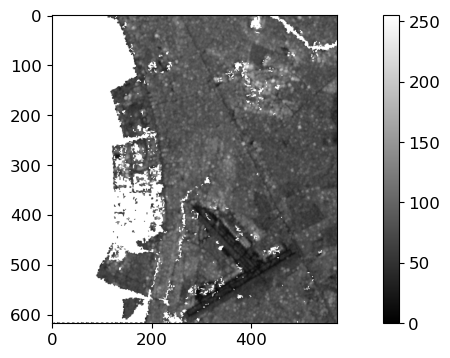

In [13]:
data_df = intensity_ll.to_dataframe()
data_df = 20 * np.log10(np.sqrt(data_df))
data_df = data_df.loc[data_df.index.get_level_values(0)[0]]
data_df = data_df.reset_index()
db_values = data_df['data']

# Normalize the decibel values to the range [0, 255]
# Step 1: Normalize the db values to the range [0, 1] based on min and max decibels
db_min = np.min(db_values)
db_max = np.max(db_values)
db_normalized = ((db_values - db_min) / (db_max - db_min)) * 255  # Scale between 0 and 1

# Replace NaN values with a default value, for example 0 (black) or 255 (white)
data_df['grayscale'] = db_normalized

# Define grid dimensions based on the unique lat/lon values
lat_values = np.sort(data_df['lat'].unique())
lon_values = np.sort(data_df['lon'].unique())
grid_shape = (len(lat_values), len(lon_values))

# Step 2: Scale to the range [0, 255]
# grayscale_values = db_normalized.fillna(255).astype(np.uint8)

# Create a 2D array (image) filled with grayscale values
image = np.full(grid_shape, 255, dtype=np.uint8)  # Start with white background

# Map lat/lon to grid indices
lat_idx = {lat: i for i, lat in enumerate(lat_values)}
lon_idx = {lon: j for j, lon in enumerate(lon_values)}

# Populate the image array with grayscale values based on correlation
for _, row in data_df.iterrows():
    i, j = lat_idx[row['lat']], lon_idx[row['lon']]
    # Handle NaN values by checking if correlation is NaN
    grayscale_value = 255 if np.isnan(row['data']) else row['grayscale']
    image[i, j] = grayscale_value

# Step 4: Display the image
plt.imshow(np.flipud(image), cmap='gray')
plt.colorbar()
plt.show()

In [25]:
PRE_FLOOD_DOI = '2018-09-04'
CO_FLOOD_DOI = '2018-09-16'

In [31]:
df_1 = intensity_ll.to_dataframe()
df_1 = df_1.reset_index()
df_1 = df_1.set_index('date')

In [38]:
np.unique(df_1.index)

array(['2018-08-23T00:00:00.000000000', '2018-09-04T00:00:00.000000000',
       '2018-09-16T00:00:00.000000000'], dtype='datetime64[ns]')

In [32]:
# generate intensity images
pre_flood_df = df_1.loc[PRE_FLOOD_DOI]
co_flood_df = df_1.loc[CO_FLOOD_DOI]
pre_flood_df.to_csv(f'csv/intensity/{PRE_FLOOD_DOI} {POLARIZATION}.csv')
co_flood_df.to_csv(f'csv/intensity/{CO_FLOOD_DOI} {POLARIZATION}.csv')
print('Saved Intensity Dataframes')

Saved Intensity Dataframes


In [44]:
df_2 = corr_ll.to_dataframe()
df_2.head()

ref        rep                   pair  correlation
lat       lon                                                                 
14.496111 120.962014 2018-08-23 2018-09-04  2018-08-23 2018-09-04          NaN
          120.962154 2018-08-23 2018-09-04  2018-08-23 2018-09-04          NaN
          120.962293 2018-08-23 2018-09-04  2018-08-23 2018-09-04          NaN
          120.962432 2018-08-23 2018-09-04  2018-08-23 2018-09-04          NaN
          120.962572 2018-08-23 2018-09-04  2018-08-23 2018-09-04          NaN

In [45]:
np.unique(df_2['rep'])

array(['2018-09-04T00:00:00.000000000'], dtype='datetime64[ns]')

In [40]:
df_2 = corr_ll.to_dataframe()
df_2 = df_2.reset_index()
df_2 = df_2.drop(columns=['ref', 'pair'])
df_2 = df_2.rename(columns={'correlation': 'data', 'rep': 'date'})
df_2 = df_2.set_index('date')

In [41]:
np.unique(df_2.index)

array(['2018-09-04T00:00:00.000000000'], dtype='datetime64[ns]')

In [34]:
# generate coherence images
pre_flood_df = df_2.loc[PRE_FLOOD_DOI]
co_flood_df = df_2.loc[CO_FLOOD_DOI]
pre_flood_df.to_csv(f'csv/coherence/{PRE_FLOOD_DOI} {POLARIZATION}.csv')
co_flood_df.to_csv(f'csv//coherence/{CO_FLOOD_DOI} {POLARIZATION}.csv')
print('Saved Coherence Dataframes')

KeyError: '2018-09-16'

# Conclusion